# Evaluating model and interpret the classification results

In [1]:
import torchray
import torch
import attr
from pathlib import Path
from torchvision import datasets, transforms
from torchray.benchmark import get_example_data, plot_example
from torchvision import models
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics as sk_metrics
from torchray.attribution.common import Probe, get_module
from torchray.attribution.grad_cam import grad_cam
from torchray.attribution.grad_cam import gradient_to_grad_cam_saliency
from PIL import Image
import cv2

In [2]:
@attr.s(auto_attribs=True)
class DataPreparation:
    data_dir: Path
    device: str = attr.ib(default=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), init=False)

    @staticmethod
    def data_transformations():
        data_transforms = {
            'test': transforms.Compose([
                transforms.CenterCrop((200, 1500)),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        return data_transforms
    
    def create_dataloaders(self, batch_size, shuffle, num_workers):
        data_transforms = self.data_transformations()
        
        image_datasets = {
            'test': datasets.ImageFolder(self.data_dir, data_transforms['test'])
        }
        dataloaders = {
            'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        }
        dataset_sizes = {
            'test': len(image_datasets['test'])
        }
        return dataloaders, dataset_sizes


In [4]:
# CHECK THIS!!!
beat = "final"

In [3]:
data_prep = DataPreparation(f'../data/figures_{beat}/test')
data, size = data_prep.create_dataloaders(16, False, 4)

In [5]:
model_path = Path().cwd().parents[0] / f"models/resnet50_d_02_t_20_10_{beat}_beat.pth"
model = torch.load(model_path)
model.eval();

In [6]:
def deprocess(image):
    transform = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        transforms.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

In [7]:
i = 0
for inputs, labels in data['test']:
    inputs = inputs.to(0)
    labels = labels.to(0)
    x = inputs
#     break
    x.requires_grad_();
    saliency_layer = get_module(model, model.layer4)
    probe = Probe(saliency_layer, target='output')
    y = model(x)
    score_max_index = y.argmax(dim=1)
    z = y[:, score_max_index]
    z.backward(torch.ones_like(z))
    saliency = gradient_to_grad_cam_saliency(probe.data[0])
    
    for index in range(len(saliency)): 
        plt.figure()
        heatmap = np.float32(saliency[index, 0].cpu().detach())
        img = np.array(deprocess(x[index].cpu().detach()))

        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)

        img1 = plt.imshow(heatmap, alpha=.7)
        img2 = plt.imshow(img, alpha=.8)
        
        plt.axis('off')
        if labels[index] == 0:
            label = "abnormal"
        else:
            label = "normal"
        ### CHANGE NAME!!!!!!!
        plt.savefig(f"../Grad_CAM_maps/label_{beat}_beat/{label}/{i}_{index}.png")
        plt.close()
        
    i += 1

-------------------------------------------------------------------------------------------------

# Grad CAM

In [24]:
saliency_layer = get_module(model, model.layer4)
probe = Probe(saliency_layer, target='output')
y = model(x)
score_max_index = y.argmax(dim=1)
z = y[:, score_max_index]
z.backward(torch.ones_like(z))

torch.Size([16, 2048, 7, 7])


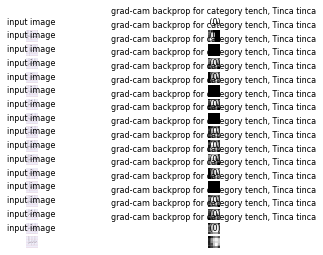

In [50]:
print(probe.data[0].size())
saliency = gradient_to_grad_cam_saliency(probe.data[0])
# Plots.
plot_example(x, saliency, 'grad-cam backprop', labels, save_path='saliency.pdf')

In [26]:
saliency.size()

torch.Size([16, 1, 7, 7])

In [47]:
index = 9

(224, 224, 3) (7, 7)
<class 'numpy.ndarray'> (224, 224)


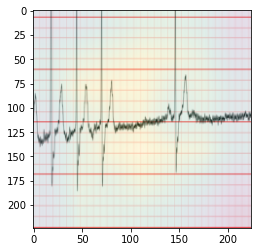

In [48]:
heatmap = np.float32(saliency[index, 0].cpu().detach())
img = np.array(deprocess(x[index].cpu().detach()))

print(img.shape, heatmap.shape)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)

print(type(heatmap), heatmap.shape)

plt.imshow(heatmap, alpha=.7)
plt.imshow(img, alpha=.8)
plt.show()

# heatmap = cv2.applyColorMap(cv2.UMat(heatmap), cv2.COLORMAP_JET)
# print(type(heatmap))
# # superimposed_img = heatmap * 0.4 + img
# superimposed_img = cv2.addWeighted(img, .4, heatmap, .4, 0)
# cv2.imwrite('./map.jpg', superimposed_img)